[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
簇0的数目： 50
簇1的数目： 65
簇2的数目： 35
簇0中实际与预测相等的数目： 50
簇1中实际与预测相等的数目： 50
簇2中实际与预测相等的数目： 35
簇0的正确率为： 1.0
簇1的正确率为： 0.7692307692307693
簇2的正确率为： 1.0


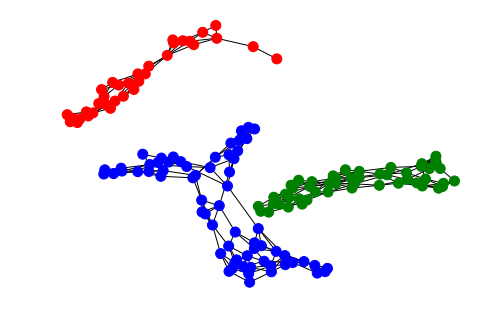

In [91]:
import numpy as np#科学计算库
from numpy import zeros
from sklearn.cluster import KMeans
import pandas as pd
import networkx as nx
from markov_clustering import mcl
from PIL import Image
import matplotlib.pyplot as plt # plt 用于显示图片
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import normalize
from scipy import linalg as LA
from math import sqrt
#导入iris数据加载器 
from sklearn.datasets import load_iris 
#使用加载器读取数据并存入变量iris
iris=load_iris() 
X = iris.data
#print(iris.data)
y = iris.target
#距离矩阵
def euclidDistance(x1, x2, sqrt_flag=False): 
    res = np.sum((x1-x2)**2) 
    if sqrt_flag: 
        res = np.sqrt(res) 
    return res 
def calEuclidDistanceMatrix(X): 
    X = np.array(X) 
    S = np.zeros((len(X), len(X))) 
    for i in range(len(X)): 
        for j in range(i+1, len(X)): 
            S[i][j] = 1.0 * euclidDistance(X[i], X[j]) 
            S[j][i] = S[i][j] 
    return S
#邻接矩阵
def myKNN(S, k, sigma): 
    N = len(S) 
    A = np.zeros((N,N)) 
    for i in range(N): 
        dist_with_index = zip(S[i], range(N)) 
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0]) 
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours 
        for j in neighbours_id: # xj is xi's neighbour 
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma) 
            A[j][i] = A[i][j] # mutually 
    return A
#标准化的拉普拉斯矩阵
def calLaplacianMatrix(adjacentMatrix): 
    # 计算度矩阵: D=sum(A) 
    degreeMatrix = np.sum(adjacentMatrix, axis=1) # 计算拉普拉斯矩阵: L=D-A 
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix 
    # normailze 
    # D^(-1/2) L D^(-1/2) 
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5))) 
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)
#相似性函数
def similarity_function(points): 
    res = rbf_kernel(points) 
    for i in range(len(res)): 
        res[i, i] = 0 
    return res 
#归一化割
def normalized_cut(points, k): 
    A = similarity_function(points) 
    S = calEuclidDistanceMatrix(points)
    #A = myKNN(S,9,1.0)
    W = np.eye(len(A)) - normalize(A, norm='l1') 
    eigvalues, eigvectors = LA.eig(W) 
    indices = np.argsort(eigvalues)[1:k] 
    return KMeans(n_clusters=k).fit_predict(eigvectors[:, indices])
#计算曼哈顿距离：
def manhattan(p,q):
    #只计算两者共同有的
    same = 0
    for i in p:
        if i in q:
            same = same + 1
    #计算曼哈顿距离
    n = same
    vals = range(n)
    distance = sum(abs(p[i] - q[i]) for i in vals)
    return distance
#转列表
def cluster_label(labels):
    labels_label = []
    for i in range(len(labels)):
        labels_label.append((i,labels[i]))
    return labels_label
#满足要求的样本点之间有连线
def change_A(A,clusters_map):
    for i in range(150):
        for j in range(150):
            if A[i][j]<0.7 or clusters_map[i][1] != clusters_map[j][1]:
                A[i][j] = 0
    return A
#类别ID
def cluster_map(labels):
    clusters_map = []
    for i,cluster in enumerate(labels):
        clusters_map.append((i,cluster))
    return clusters_map
#各类别所属颜色
def colors(cluster_map,len_nodes):
    colors_0 = []
    colors_1 = []
    colors_2 = []
    node_color = []
    for i in range(len_nodes):
        if cluster_map[i][1]==0:
            color = 'g'
            colors_0.append(color)
        elif cluster_map[i][1]==1:
            color = 'b'
            colors_1.append(color)
        else:
            color = 'r'
            colors_2.append(color)
        node_color.append(color)
    return node_color
#各类别所属形状
def shapes(cluster_map,len_nodes):
    shapes_0 = []
    shapes_1 = []
    shapes_2 = []
    node_shape = []
    for i in range(len_nodes):
        if cluster_map[i][1]==0:
            shape = '^'
            shapes_0.append(shape)
        elif cluster_map[i][1]==1:
            shape = 's'
            shapes_1.append(shape)
        else:
            shape = 'o'
            shapes_2.append(shape)
        node_shape.append(shape)
    return node_shape
#计算各个簇的样本数目
def cluster_num(labels):
    count_0 = 0
    count_1 = 0
    count_2 = 0
    for i in range(len(labels)):
        if labels[i] == 0:
            count_0 = count_0+1
        elif labels[i] == 1:
            count_1 = count_1+1
        else:
            count_2 = count_2+1
    print('簇0的数目：',count_0)
    print('簇1的数目：',count_1)
    print('簇2的数目：',count_2)
    return count_0,count_1,count_2
#预测
def predict(labels,y,count_0,count_1,count_2):
    num_0 = 0
    num_1 = 0
    num_2 = 0
    for i in range(len(labels)):
        if labels[i]==0 and labels[i]==y[i]:
            num_0 = num_0+1
        if labels[i]==1 and labels[i]==y[i]:
            num_1 = num_1+1
        if labels[i]==2 and labels[i]==y[i]:
            num_2 = num_2+1
    print('簇0中实际与预测相等的数目：',num_0)
    print('簇1中实际与预测相等的数目：',num_1)
    print('簇2中实际与预测相等的数目：',num_2)
    pre_0 = num_0/count_0
    pre_1 = num_1/count_1
    pre_2 = num_2/count_2
    return pre_0,pre_1,pre_2




# map node to cluster id for colors
#print(type(labels))
#cluster_map = {node: i for i, cluster in enumerate(labels) for node in labels}
#colors = [clusters_map[i] for i in range(len(G.nodes()))]

S = calEuclidDistanceMatrix(X)
A = myKNN(S,4,1.0) 
L = calLaplacianMatrix(A)

labels = normalized_cut(X, 3)
print(labels)
print(y)

count_0,count_1,count_2 = cluster_num(labels)
pre_0,pre_1,pre_2 = predict(labels,y,count_0,count_1,count_2)
print('簇0的正确率为：',pre_0)
print('簇1的正确率为：',pre_1)
print('簇2的正确率为：',pre_2)

clusters_map = cluster_map(labels)
#labels_label = cluster_label(labels)
A = change_A(A,clusters_map)
G = nx.Graph(A)
len_nodes = len(G.nodes())
node_colors = colors(clusters_map,len_nodes)
node_shapes = shapes(clusters_map,len_nodes)
#print(node_shapes)
nx.draw(G,node_color=node_colors,node_size=100)
plt.show()

#print(type(labels))
#print(node_shape)